# Lecture 2: Network nonparametrics
#### Econometric Methods for Social Spillovers and Networks
#### _University of St. Gallen, September 26th to October 3rd, 2016_
##### _Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu_
<br>
<br>
This is the second of a series of iPython Jupyter notebooks designed to accompany a series of instructional lectures given at the University of St. Gallen from September 26th to October 3rd, 2016. The scripts below were written for Python 2.7.12. The Anaconda distribution of Python, available at https://www.continuum.io/downloads, comes bundled with most the scientific computing packages used in these notebooks.
<br>
<br>
For more information about the course please visit my webpage at http://bryangraham.github.io/econometrics/.
<br>
<br>
In this notebook I illustrate how to estimate network edge probabilitys nonparametrically. I use a variant of the procedure introduced by Zhang et al. (2015, _ArXiv_) as described in the course notes. Also included is an implementation of the general purpose matrix estimation method discussed in Chatterjee (2015, _Annals of Statistics_)

In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import time

# main scientific computing modules
import numpy as np
import scipy as sp
from scipy.spatial.distance import cdist

# additional modules, mostly for presentation
import matplotlib.pyplot as plt
import itertools as it

# Division of two integers in Python 2.7 does not return a floating point result. The default is to round down 
# to the nearest integer. The following piece of code changes the default.
from __future__ import division

In [2]:
# Directory where graphics files will be saved
graphics =  '/Users/bgraham/Dropbox/Teaching/Short_Courses/St_Gallen/Lectures/'

I begin by defining a nearest neighbor smoothing function as described in the lecture notes.

In [3]:
def NNEdgeSmooth(D, K=None):
    """
    
    AUTHOR: Bryan S. Graham (https://github.com/bryangraham)
    NOTES: Code adapted from script by Yun-Jhong Wu
           (https://github.com/yunjhongwu/matrix-routines)
    
    Python implementation of a variant of algorithm proposed by
    Zhang, Y., Levina, E. and Zhu, J. (2016) Estimating neighborhood edge 
    probabilities by neighborhood smoothing. arXiv: 1509.08588. 
    
    The implemention uses nearest neighbors defined in terms of a Euclidean
    distance metric and not the Chebyshev norm used in the paper. 
    
    INPUTS:
    -------
    D   :   Symmetric adjacency matrix
    K   :   Number of nearest neighbors to include
    
    OUTPUTS:
    --------
    P   :   Estimate of edge probabilities
    
    Output: Estimated probaility matrix
    """
    
    # Number of agents
    N = D.shape[0]
    
    # If Nearest neighbors not specified using Zhange et al. (2015)
    # proposed rule-of-thumb
    if K is None:
        K = 0.1*np.sqrt(N*np.log(N))
    
    D2 = np.dot(D, D.T)                   # Matrix square of the adjacency matrix
    d_bar = cdist(D2, D2, 'euclidean')    # Euclidean distance across rows/columns
    
    # Correct distance estimates to reflect that ith and jth elements of each
    # vector should be removed prior to computing distance between ith and jth rows
    # NOTE: This correction is generally not important when N is large
    for (i,j) in it.combinations(xrange(0,N), 2):
        d_bar[i,j] = ((d_bar[i,j]**2 - (D2[i,i] - D2[i,j])**2 - (D2[j,i] - D2[j,j])**2)**(1/2))/(N-2) 
        d_bar[j,i] = d_bar[i,j] 
    
    # Find K nearest neighbors
    # Boolean matrix with (i,j) equal to True if agent i is among the K
    # nearest neighbors to agent j (i.e., percentiles taken across columns)
    K = d_bar < np.percentile(d_bar, (K/N)*100, 0, interpolation='lower')
    
    # Compute estimate of edge probabilities
    # Each element gives average of D_il when l indices agent j's nearest neighbors
    P = np.dot(D, (K * (1 / (np.sum(K, 0) + 1e-10))))

    return (P + P.T) * 0.5  # Return average of two means as in Zhang et al. (2015)

I also define a function implementing the Universal Singular Value Thresholding (USVT) method introduced in Chatterjee (2015, _Annals of Statistics_).

In [47]:
def USVT(D):
    
    """
    AUTHOR: Bryan S. Graham (https://github.com/bryangraham)
   
    Python implementation of a variant of algorithm proposed by
    Chatterjee (2015, Annals of Statistics) "Matrix estimation by 
    universal singular value thresholding."
    
    INPUTS:
    -------
    D   :   Binary matrix (M x N)
   
    OUTPUTS:
    -------
    P   :   Estimate of E[P] 
    """
    
    N = D.shape[1]  # Number of columns in the matrix 
    X = 2*(D - 1/2) # Center elements of binary matrix to line between -1 and 1
    U, s, V = np.linalg.svd(X, full_matrices=True) # Get SVD
    USVT = (s >= (2+0.01)*(N**0.5)) # Set of larger singula value to retain
    
    # Construct matrix approximation and rescale to line on unit interval
    W = np.dot(np.dot(U,np.diag(USVT*s)),V) 
    W = W*(W>=-1)*(W<=1) - 1*(W<-1) + 1*(W>1)    
    
    return 0.5 + 0.5*W

Next I take a random draw of a network with $N = 2,000$ agents using the graphon described and plotted in the lecture notes.

In [37]:
# Set random number seed
randst = np.random.RandomState(19)

# Set network size
N = 2000
n = N*(N - 1) // 2

# Get multi-indices for lower triangle of N x N matrix
ij_LowTri = np.tril_indices(N, -1)

# Draw agent-level heterogeneity/location parameters
U = randst.uniform(0, 1, (N,1))

# Calibrate model to ensure link probabilities lie between zero and one
alpha0 = 0;
alpha1 = 0.5*np.log(0.75/0.25)
alpha2 = np.log(0.25/0.75) - alpha1

# Graphon discussed in the lecture notes
p  = 1/(1+np.exp(-alpha0 - alpha1*(U + U.T) - alpha2*np.abs(U - U.T)))

# Graphon #3 in Zhang, Levina and Zhu (2015)
#p  = 1 - (1 + np.exp(15*np.abs(0.8*(U - U.T))**(4/5) - 0.1))**-1

# Graphon #4 in Zhang, Levina and Zhu (2015)
#p  = (U**2 + (U.T)**2)/(3*np.cos(1/(U**2 + (U.T)**2))) + 0.15

# Take random draw of an adjacency matrix for given graphon
D            = np.zeros((N,N), dtype='float64')   # N x N adjacency matrix
D[ij_LowTri] = np.ravel(randst.uniform(0, 1, (n,)) <= p[ij_LowTri])
D            = D + D.T

Construct a heatmap/contour plot of simulated graphon.

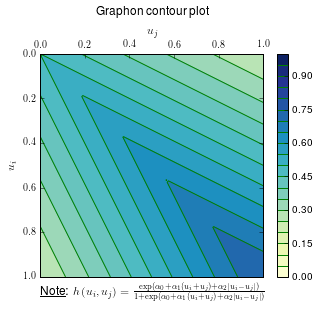

In [38]:
# Plot test graphon function

# Create mesh grid of x, y, z values
U_grid  = np.linspace(0, 1, 100)
u, v    = np.meshgrid(U_grid, U_grid)
h       = 1/(1+np.exp(-alpha0 - alpha1*(u + v) - alpha2*np.abs(u - v))) #Homophily graphon

# Create figure object
graphon_ex_fig = plt.figure(figsize=(5,4))
ax = graphon_ex_fig.add_subplot(111)

# Create contour "heat map" with 20 levels
cs1 = ax.contourf(u, v, h, levels=np.linspace(0, 1, 21), \
           origin='upper', extent=(0,1,0,1), cmap="YlGnBu")

# Add contour lines to plot
cs2 = plt.contour(cs1, \
                  colors='green', linewidths = 1)
# Add color bar
cbar = graphon_ex_fig.colorbar(cs1, format="%.2f").add_lines(cs2)

# Label and configure axes to put graphon plot in "matrix form"
# (i.e., place origin in upper-left-hand corner)
ax.xaxis.tick_top() # Put x-axis on top of figure
ax.set_xlabel(r'$u_{j}$', fontsize=12)
ax.xaxis.set_label_position('top') 

ax.invert_yaxis()  # Invert y-axis 
ax.set_ylabel(r'$u_{i}$', fontsize=12)

# Add title
plt.title("Graphon contour plot", y=1.15, fontsize=12)

# Add graphon equation as note at the bottom of the plot
from matplotlib import rc
rc('text', usetex=True)
plt.text(0, 1.1, r'\underline{Note}: $h\left(u_{i},u_{j}\right)=\frac{\exp\left(\alpha_{0}+\alpha_{1}\left(u_{i}+u_{j}\right) \
                   +\alpha_{2}\left|u_{i}-u_{j}\right|\right)}{1+\exp\left(\alpha_{0}+\alpha_{1}\left(u_{i}+u_{j}\right) \
                   +\alpha_{2}\left|u_{i}-u_{j}\right|\right)}$', fontsize=12)


# Save the figure
plt.savefig(graphics+'graphon_ex_fig.png', bbox_inches='tight', dpi=500)

Next estimate the edge probabilities nonparametrically using 100 nearest neighbors. 

In [39]:
P_ns = NNEdgeSmooth(D,100)

Plot a random selection of the estimated probabilities against their actual counterparts.

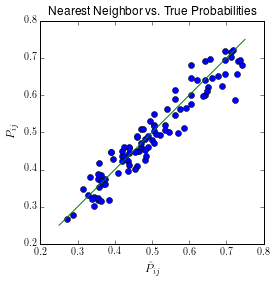

In [43]:
# Plot fitted probabilities against true ones

# Create figure object
Phat_vs_P0_fig = plt.figure(figsize=(4,4))
ax = Phat_vs_P0_fig.add_subplot(111)

# Plot estimated probalities for a random choice of 100 agents
random_indices = np.random.choice(n, 100)
plt.plot(P_ns[ij_LowTri][random_indices], p[ij_LowTri][random_indices], 'o')
plt.plot([0.25,0.75],[0.25,0.75],'-')

# Label and configure axes
# (i.e., place origin in upper-left-hand corner)
ax.set_xlabel(r'$\hat{P}_{ij}$', fontsize=12)
ax.set_ylabel(r'$P_{ij}$', fontsize=12)

# Add title
plt.title("Nearest Neighbor vs. True Probabilities", y=1, fontsize=12)

Estimate edge probabilities using Chatterjee's (2015) general purpose thresholding estimator.

In [45]:
P_usvt = USVT(D)

Goodness of fit plot.

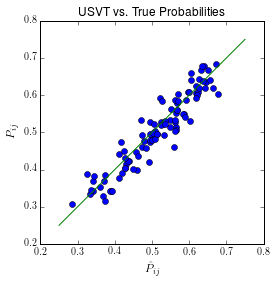

In [46]:
# Plot fitted probabilities against true ones

# Create figure object
Phat_vs_P0_fig = plt.figure(figsize=(4,4))
ax = Phat_vs_P0_fig.add_subplot(111)

# Plot estimated probalities for a random choice of 100 agents
random_indices = np.random.choice(n, 100)
plt.plot(P_usvt[ij_LowTri][random_indices], p[ij_LowTri][random_indices], 'o')
plt.plot([0.25,0.75],[0.25,0.75],'-')

# Label and configure axes
# (i.e., place origin in upper-left-hand corner)
ax.set_xlabel(r'$\hat{P}_{ij}$', fontsize=12)
ax.set_ylabel(r'$P_{ij}$', fontsize=12)

# Add title
plt.title("USVT vs. True Probabilities", y=1, fontsize=12)

Construct pixel plot of simulated adjacency matrix and (i) our smoothed and (ii) USVT estimate of the underlying graphon.

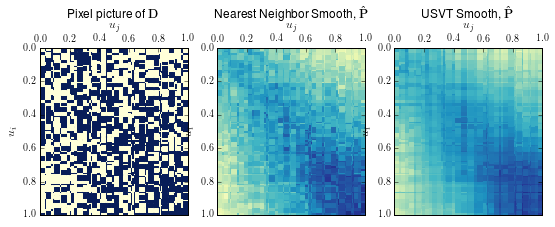

In [49]:
# Create n = N choose 2 vectors with the dyad types as values
u = np.zeros((N,N))
v = np.zeros((N,N))

for (i,j) in it.combinations(xrange(0,N), 2):
    u[i,j] = U[i]
    v[i,j] = U[j]
    
u = u + u.T
v = v + v.T

#--------------------------------------------#
#- Create figure object with three subplots -#
#--------------------------------------------#

pixel_ex_fig = plt.figure(figsize=(9,3))

# Plot 1: Plot pixel picture of adjacency matrix
ax = pixel_ex_fig.add_subplot(131)

# Scatter of adjacency matrix; edgecolors of pixels same as faces
plt.scatter(v[ij_LowTri],u[ij_LowTri],c=D[ij_LowTri], marker='s', cmap="YlGnBu", \
            edgecolors='face')

# Set axis limits 
plt.ylim([0,1])
plt.xlim([0,1])

# Label and configure axes to put pixel plot in "matrix form"
ax.xaxis.tick_top() # Put x-axis on top of figure
ax.set_xlabel(r'$u_{j}$', fontsize=12)
ax.xaxis.set_label_position('top') 

ax.invert_yaxis()  # Invert y-axis 
ax.set_ylabel(r'$u_{i}$', fontsize=12)

# Add title
plt.title(r"Pixel picture of $\mathbf{D}$", y=1.15, fontsize=12)

# Plot 2: Plot pixel picture of Nearest Neighbor Smooth
ax = pixel_ex_fig.add_subplot(132)

# Scatter
plt.scatter(v[ij_LowTri],u[ij_LowTri],c=P_ns[ij_LowTri], marker='s', cmap="YlGnBu", \
            edgecolors='face')

# Set axis limits 
plt.ylim([0,1])
plt.xlim([0,1])

# Label and configure axes to put pixel plot in "matrix form"
ax.xaxis.tick_top() # Put x-axis on top of figure
ax.set_xlabel(r'$u_{j}$', fontsize=12)
ax.xaxis.set_label_position('top') 

ax.invert_yaxis()  # Invert y-axis 
ax.set_ylabel(r'$u_{i}$', fontsize=12)

# Add title
plt.title(r"Nearest Neighbor Smooth, $\mathbf{\hat{P}}$", y=1.15, fontsize=12)

# Plot 3: Plot pixel picture of USVT Smooth
ax = pixel_ex_fig.add_subplot(133)

# Scatter
plt.scatter(v[ij_LowTri],u[ij_LowTri],c=P_usvt[ij_LowTri], marker='s', cmap="YlGnBu", \
            edgecolors='face')

# Set axis limits 
plt.ylim([0,1])
plt.xlim([0,1])

# Label and configure axes to put pixel plot in "matrix form"
ax.xaxis.tick_top() # Put x-axis on top of figure
ax.set_xlabel(r'$u_{j}$', fontsize=12)
ax.xaxis.set_label_position('top') 

ax.invert_yaxis()  # Invert y-axis 
ax.set_ylabel(r'$u_{i}$', fontsize=12)

# Add title
plt.title(r"USVT Smooth, $\mathbf{\hat{P}}$", y=1.15, fontsize=12)

# Save the figure
plt.savefig(graphics+'pixel_smooth_ex_fig.png', bbox_inches='tight', dpi=500)

In [50]:
# This imports an attractive notebook style from Github
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())